# Baseline model for batch monitoring example

In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ColumnQuantileMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

/opt/anaconda3/envs/mlopszoomcamp/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda3/envs/mlopszoomcamp/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda3/envs/mlopszoomcamp/lib/python3.8/site-packages/umap/distanc

In [2]:
#files = [('green_tripdata_2022-02.parquet', '../data/green_taxi'), ('green_tripdata_2022-01.parquet', '../data/green_taxi')]
files = [('green_tripdata_2023-03.parquet', '../data/green_taxi')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2023-03.parquet: 100%|███████████████████████████████████████████████████████████████| 1730999/1730999 [00:19<00:00, 87678.85it/s, save to ../data/green_taxi/green_tripdata_2023-03.parquet]


In [3]:
mar_data = pd.read_parquet('../data/green_taxi/green_tripdata_2023-03.parquet')

In [4]:
mar_data.describe() # Q1: 72044 lines

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,72044.000000,67507.000000,72044.000000,72044.000000,67507.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,0.0,72044.000000,72044.000000,67507.000000,67500.000000,67507.000000
mean,1.865443,1.145703,98.437413,137.613556,1.286844,12.449511,17.018203,0.878109,0.576929,2.157651,0.183268,NaN,0.961604,22.292310,1.373680,1.028681,0.714837
std,0.341252,1.225735,60.481870,76.169705,0.923652,641.094653,13.832399,1.297642,0.384129,3.136215,1.139159,NaN,0.185185,15.852047,0.512307,0.166911,1.206435
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-115.000000,-5.000000,-0.500000,-1.100000,0.000000,NaN,-1.000000,-116.000000,1.000000,1.000000,-2.750000
25%,2.000000,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.980000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,75.000000,138.000000,1.000000,1.840000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,18.100000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,129.000000,216.000000,1.000000,3.300000,20.000000,1.000000,0.500000,3.360000,0.000000,NaN,1.000000,26.730000,2.000000,1.000000,2.750000
max,2.000000,99.000000,265.000000,265.000000,9.000000,92064.680000,477.000000,12.500000,4.250000,270.270000,36.050000,NaN,1.000000,478.000000,5.000000,2.000000,2.750000


In [5]:
mar_data.shape # Q1: 72044 lines

(72044, 20)

In [6]:
# create target
mar_data["duration_min"] = mar_data.lpep_dropoff_datetime - mar_data.lpep_pickup_datetime
mar_data.duration_min = mar_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [7]:
# filter out outliers
mar_data = mar_data[(mar_data.duration_min >= 0) & (mar_data.duration_min <= 60)]
mar_data = mar_data[(mar_data.passenger_count > 0) & (mar_data.passenger_count <= 8)]

<Axes: >

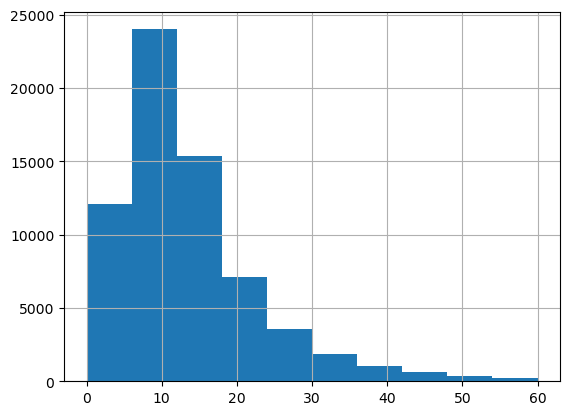

In [8]:
mar_data.duration_min.hist()

In [9]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [10]:
mar_data.shape

(66255, 21)

In [11]:
train_data = mar_data[:30000]
val_data = mar_data[30000:]

In [12]:
model = LinearRegression()

In [13]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [14]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [15]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [16]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.564175957106492
3.646951695051199


# Dump model and reference data

In [17]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [18]:
val_data.to_parquet('../data/reference.parquet')

# Evidently Report

In [19]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [20]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric(),
    ColumnQuantileMetric(column_name='fare_amount', quantile=0.5) # Q2: ColumnQuantileMetric
]
)

In [21]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [22]:
#report.show(mode='inline')

In [23]:
result = report.as_dict()

In [24]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': 0.021912744737353454,
    'drift_detected': False,
    'current': {'small_distribution': {'x': [-29.976938687069932,
       -6.360433663687477,
       17.256071359694978,
       40.87257638307743,
       64.48908140645989,
       88.10558642984235,
       111.72209145322479,
       135.33859647660728,
       158.95510149998972,
       182.57160652337217,
       206.1881115467546],
      'y': [9.343432451141222e-06,
       0.0344305485824554,
       0.007515623477886722,
       0.00034570700069222514,
       2.335858112785305e-05,
       8.175503394748573e-06,
       5.839645281963255e-06,
       1.1679290563926532e-06,
       2.3358581127853063e-06,
       1.1679290563926532e-06]}},
    'reference': {'small_distribution': {'x': [-44.794580269945925,
       -20.70570087291

In [25]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.021912744737353454

In [26]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [27]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

0.0454570529456752

In [29]:
#column quantile metric
result['metrics'][3]['result']['current']['value']

12.8